<a href="https://colab.research.google.com/github/IshaanKetchup/ML-tools-and-techniques/blob/main/Reinforcement%20Learning%20-%20Q%20Learning%20vs.%20Policy%20Gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy tensorflow matplotlib

#Activity Description
 simple grid environment (5 × 5) in which the agent starts at a random position and must navigate to a goal state while avoiding pitfalls. The environment includes:

States: each cell on the grid is a unique state.

Actions: the agent can move up, down, left, or right.

Rewards:

+10 for reaching the goal state (position 24).

–10 for falling into a pit (position 12).

–1 for all other movements (to encourage faster goal-reaching).

#Q Learning


##Initialize Q table

In [1]:
import numpy as np

# Define the grid size and actions
grid_size = 5
n_actions = 4  # Actions: up, down, left, right

# Initialize the Q-table with zeros
Q_table = np.zeros((grid_size * grid_size, n_actions))

##Define Hyperparameters

In [2]:
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor for future rewards
epsilon = 0.1  # Exploration rate for epsilon-greedy policy

##Define Reward Structure

In [3]:
# Reward matrix for the grid environment
rewards = np.full((grid_size * grid_size,), -1)  # -1 for every state
rewards[24] = 10  # Goal state
rewards[12] = -10  # Pitfall state

##Implement Epsilon Greedy

In [4]:
def epsilon_greedy_action(Q_table, state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.randint(0, n_actions)  # Explore: random action
    else:
        return np.argmax(Q_table[state])  # Exploit: action with highest Q-value

##Update Q-Values

In [5]:
rewards_q_learning = []  # Track total reward per episode
for episode in range(1000):
    state = np.random.randint(0, grid_size * grid_size)
    done = False
    total_reward = 0  # Track cumulative reward this episode

    while not done:
        action = epsilon_greedy_action(Q_table, state, epsilon)
        next_state = np.random.randint(0, grid_size * grid_size)  # Simulated transition
        reward = rewards[next_state]
        total_reward += reward

        # Bellman update
        Q_table[state, action] += alpha * (
            reward + gamma * np.max(Q_table[next_state]) - Q_table[state, action]
        )

        state = next_state

        # Stop episode if agent reaches goal or pit
        if state == 24 or state == 12:
            done = True

    rewards_q_learning.append(total_reward)


#Policy Gradient

##Build Policy Network

In [10]:
import tensorflow as tf

# Define the policy network
n_states = grid_size * grid_size  # Number of states in the grid
n_actions = 4  # Up, down, left, right

model = tf.keras.Sequential([
    tf.keras.layers.Dense(24, activation='relu', input_shape=(n_states,)),
    tf.keras.layers.Dense(n_actions, activation='softmax')  # Output action probabilities
])

# Optimizer for policy network updates
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

##Select Action

In [11]:
def get_action(state):
    state_input = tf.one_hot(state, n_states)  # One-hot encoding for state
    action_probs = model(state_input[np.newaxis, :])
    return np.random.choice(n_actions, p=action_probs.numpy()[0])

##Simulate Environment

##Compute Cumulative Rewards

In [13]:
def compute_cumulative_rewards(rewards, gamma=0.99):
    cumulative_rewards = np.zeros_like(rewards)
    running_add = 0
    for t in reversed(range(len(rewards))):
        running_add = running_add * gamma + rewards[t]
        cumulative_rewards[t] = running_add
    return cumulative_rewards

##Update Policy

In [14]:
def update_policy(states, actions, rewards):
    cumulative_rewards = compute_cumulative_rewards(rewards)

    with tf.GradientTape() as tape:
        state_inputs = tf.one_hot(states, n_states)  # Convert states to one-hot encoding
        action_probs = model(state_inputs)
        action_masks = tf.one_hot(actions, n_actions)  # Mask for selected actions
        log_probs = tf.reduce_sum(action_masks * tf.math.log(action_probs), axis=1)

        # Policy loss is the negative log-probability of the action times the cumulative reward
        loss = -tf.reduce_mean(log_probs * cumulative_rewards)

    # Apply gradients to update the policy network
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [18]:
rewards_policy_gradients = []  # Track total reward per episode

for episode in range(1000):
    state = np.random.randint(0, n_states)
    done = False

    episode_states = []
    episode_actions = []
    episode_rewards = []

    while not done:
        action = get_action(state)
        next_state = np.random.randint(0, n_states)
        reward = rewards[next_state]

        episode_states.append(state)
        episode_actions.append(action)
        episode_rewards.append(reward)

        state = next_state
        if next_state in {24, 12}:  # goal or pit
            done = True

    # Update policy after the episode
    update_policy(episode_states, episode_actions, episode_rewards)

    # Track cumulative reward for this episode
    total_reward = sum(episode_rewards)
    rewards_policy_gradients.append(total_reward)


#Comparison and Analysis

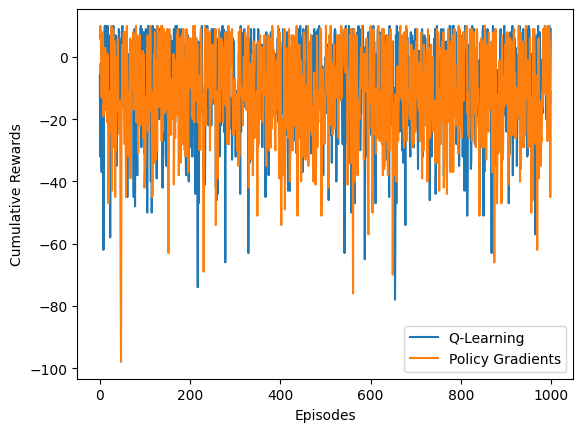

In [19]:
import matplotlib.pyplot as plt

# Example code to visualize rewards over episodes
plt.plot(rewards_q_learning, label='Q-Learning')
plt.plot(rewards_policy_gradients, label='Policy Gradients')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Rewards')
plt.legend()
plt.show()

1. High Variance (Spiky Behavior)
Both Q-Learning and Policy Gradients have high variance in their episode rewards.

You can see a lot of sudden drops down to –50, –70, or even –100. These represent episodes where the agent fell into the pit or wandered inefficiently before reaching the goal.

2. No Clear Upward Trend
Ideally, over time, you'd expect the reward to trend upward (closer to 10 consistently), showing that the agent is learning to reach the goal efficiently.

\\
In this plot, there's no consistent increase in either line. That means:

The agents are not reliably improving.

The training setup likely has issues—either:

The environment is too stochastic (random),

The rewards are too sparse,

The learning rates or exploration settings aren't tuned properly.

3. Policy Gradients are Slightly More Stable
The orange line (Policy Gradients) looks more clustered toward higher rewards compared to Q-Learning.

But it still shows frequent bad episodes.